In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import GPy

from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display
GPy.plotting.change_plotting_library('matplotlib')

# Helpers

In [2]:
def filter_by_coordinates(data, coordinate_limits):
    """
    Returns the filtered coordinates from the dataset.
    
    Params:
        - coordinate_limits (tuple): in the format (MIN_LAT, MIN_LNG, MAX_LAT, MAX_LNG)
    
    Returns:
        - numpy matrix that consists only of the filtered data
    """ 
    min_lat, min_lng, max_lat, max_lng = coordinate_limits
    
    f1 = data[data[:, 0] > min_lat]
    f2 = f1[f1[:, 0] < max_lat]
    f3 = f2[f2[:, 1] > min_lng]
    f4 = f3[f3[:, 1] < max_lng]

    return f4

def load_data(filename, coordinates):
    data = filter_by_coordinates(np.load(filename), coordinates)    
    X, y = data[:,0:3], data[:,3]
    y -= y.mean()
    X[:,2] -= X[:,2].min()

    return X, y

def run_gp(dataset, kernel, coordinates):
    """
    Runs the entire GP as a single method and returns the trained model. It is possible to continue
    training it with restarts after the initial training.
    
    Params:
        - dataset (str): name of dataset in `.npy` format to train the GP
        - kernel: GPy kernel object that defines the covariance function of our GP
        - top_left (tuple): (LAT, LNG) of the top left corner of our area concerned
        - bottom_right (tuple): (LAT, LNG) of the bottom right corner of our area concerned

    Returns:
        - a trained GPy model
    """
    X, y = load_data(dataset, coordinates)
    
    print('Training GP...')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')
    
    model = GPy.models.GPRegression(X, y[:,None], kernel)
    model.optimize(messages=True)
    
    display(model)
    print('Log Likelihood: ' + str(model.log_likelihood()))
    
    return model

# Kernel

Define your kernel here.

In [7]:
def get_kernel():
    kernel = GPy.kern.Matern32(2, active_dims=[0, 1]) + GPy.kern.StdPeriodic(1, active_dims=[2])
    return kernel

# Datasets

Store your datasets as a list of strings.

In [8]:
sizes = [200, 400]
sk_datasets = [f'../data/sk-filtered_data-{size}.npy' for size in sizes]
tp_datasets =[f'../data/tp-filtered_data-{size}.npy' for size in sizes]

# Tampines

In [9]:
MAX_AREA = (1.351800, 103.943283, 1.360377, 103.957675)

tp_models = []
for dataset in tp_datasets:
    model = run_gp(dataset, get_kernel(), MAX_AREA)
    tp_models += [model]

Training GP...
X shape: (2304, 3)
y shape: (2304,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s02  0002   6.932794e+03   2.045854e+06 
    26s30  0009   5.395738e+03   5.868848e+07 
 01m18s54  0027   5.389690e+03   1.801763e+11 
 01m44s50  0036   5.389636e+03   1.843550e+02 
Runtime:  01m44s50
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.Mat32.variance,1.01017972918,+ve,
sum.Mat32.lengthscale,0.978749998844,+ve,
sum.std_periodic.variance,0.995496291739,+ve,
sum.std_periodic.period,0.88019526558,+ve,
sum.std_periodic.lengthscale,1.01118795361,+ve,
Gaussian_noise.variance,6.2778584383,+ve,


Log Likelihood: -5389.63638647
Training GP...
X shape: (1552, 3)
y shape: (1552,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    10s61  0009   6.608118e+03   2.109139e+08 
    11s79  0010   6.246920e+03   9.205210e+07 
    22s61  0019   5.703669e+03   1.099385e+06 
    40s41  0034   5.663438e+03   5.250361e+04 
    42s80  0036   5.663438e+03   6.259345e+02 
Runtime:     42s80
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.Mat32.variance,1.16340244733,+ve,
sum.Mat32.lengthscale,0.714873246508,+ve,
sum.std_periodic.variance,0.999574781009,+ve,
sum.std_periodic.period,0.908356988276,+ve,
sum.std_periodic.lengthscale,1.0003524549,+ve,
Gaussian_noise.variance,86.3261440652,+ve,


Log Likelihood: -5663.43761165


# Sengkang

In [10]:
MAX_AREA = (1.382030, 103.888635, 1.402076, 103.909292)

sk_models = []
for dataset in sk_datasets:
    model = run_gp(dataset, get_kernel(), MAX_AREA)
    sk_models += [model]

Training GP...
X shape: (2904, 3)
y shape: (2904,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    28s41  0006   5.480897e+03   4.539887e+05 
 01m30s07  0019   5.480720e+03   3.526632e+07 
 02m37s21  0033   5.476130e+03   2.134630e+03 
Runtime:  02m37s21
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.Mat32.variance,1.0677970893,+ve,
sum.Mat32.lengthscale,0.872887595006,+ve,
sum.std_periodic.variance,0.999838496111,+ve,
sum.std_periodic.period,1.00048634753,+ve,
sum.std_periodic.lengthscale,1.00004334556,+ve,
Gaussian_noise.variance,2.50617136081,+ve,


Log Likelihood: -5476.13034889
Training GP...
X shape: (2820, 3)
y shape: (2820,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    20s31  0004   9.853912e+03   2.359921e+09 
    52s69  0010   7.572534e+03   3.220523e+06 
 02m37s57  0030   6.979355e+03   5.209544e+09 
 06m28s00  0080   4.587479e+03   1.564968e+06 
 06m36s81  0082   4.587479e+03   2.593080e+02 
Runtime:  06m36s81
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.Mat32.variance,17.373969415,+ve,
sum.Mat32.lengthscale,8.5544898988e-32,+ve,
sum.std_periodic.variance,0.847479473147,+ve,
sum.std_periodic.period,1.11455457288,+ve,
sum.std_periodic.lengthscale,1.44895944659,+ve,
Gaussian_noise.variance,1.40240738518,+ve,


Log Likelihood: -4587.47931685


## Restart Optimization (if needed)

In [11]:
def restart_optimize(num_restarts, models):
    for model in models:
        model.optimize_restarts(num_restarts=num_restarts)

In [38]:
restart_optimize(20, sk_models)
restart_optimize(20, tp_models)

Optimization restart 1/20, f = 2828.939673047294


 /Users/xbili/.pyenv/versions/3.6.2/envs/cs4246/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:123: RuntimeWarning:overflow encountered in true_divide
 /Users/xbili/.pyenv/versions/3.6.2/envs/cs4246/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:124: RuntimeWarning:invalid value encountered in sin


Optimization restart 2/20, f = 5299.424489920424
Optimization restart 3/20, f = 5531.537779745812
Optimization restart 4/20, f = 2833.5435247420573
Optimization restart 5/20, f = 7127.725366446097
Optimization restart 6/20, f = 6641.426089713804
Optimization restart 7/20, f = 5987.144304401068
Optimization restart 8/20, f = 5699.078851847534
Optimization restart 9/20, f = 8902.626618123391
Optimization restart 10/20, f = 5500.861676497795
Optimization restart 11/20, f = 5366.708595392217
Optimization restart 12/20, f = 2843.7032899490596
Optimization restart 13/20, f = 8021.008536091809
Optimization restart 14/20, f = 6810.900509630366
Optimization restart 15/20, f = 2828.026321443819
Optimization restart 16/20, f = 5563.18865448545
Optimization restart 17/20, f = 2839.0141366404637
Optimization restart 18/20, f = 5993.753424187047
Optimization restart 19/20, f = 11618.13447726192
Optimization restart 20/20, f = 10609.18078370027
Optimization restart 1/20, f = 4587.479316841791
Optimiz

 /Users/xbili/.pyenv/versions/3.6.2/envs/cs4246/lib/python3.6/site-packages/GPy/kern/src/stationary.py:430: RuntimeWarning:overflow encountered in multiply
 /Users/xbili/.pyenv/versions/3.6.2/envs/cs4246/lib/python3.6/site-packages/GPy/kern/src/stationary.py:430: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/20, f = 35608.55729139027
Optimization restart 4/20, f = 31834.414535912045
Optimization restart 5/20, f = 24823.485188602466
Optimization restart 6/20, f = 14575.050553357349
Optimization restart 7/20, f = 7953.4987402745555
Optimization restart 8/20, f = 17438.015899311136
Optimization restart 9/20, f = 4615.732033917653
Optimization restart 10/20, f = 29055.856582634628
Optimization restart 11/20, f = 4676.867860399769
Optimization restart 12/20, f = 119305.38782865624
Optimization restart 13/20, f = 32984.60507484064
Optimization restart 14/20, f = 13095.276126837849
Optimization restart 15/20, f = 31126.5313051074
Optimization restart 16/20, f = 32605.780427963346
Optimization restart 17/20, f = 28319.547475115396
Optimization restart 18/20, f = 14786.905544654512
Optimization restart 19/20, f = 24001.04932472773
Optimization restart 20/20, f = 4612.91090903052
Optimization restart 1/20, f = 3111.211306294883
Optimization restart 2/20, f = 7876.495297865541


# Analysis of models

In [39]:
print('Tampines')
for dataset, model in zip(sk_datasets, sk_models):
    print(f'{dataset}: {model.log_likelihood()}')
    
print('Sengkang')
for dataset, model in zip(tp_datasets, tp_models):
    print(f'{dataset}: {model.log_likelihood()}')

Tampines
../data/sk-filtered_data-200.npy: -2828.026321443819
../data/sk-filtered_data-400.npy: -4587.479316841791
Sengkang
../data/tp-filtered_data-200.npy: -3103.225818483352
../data/tp-filtered_data-400.npy: -3141.156686032937


In [43]:
MAX_AREA = (1.382030, 103.888635, 1.402076, 103.909292)
X, y = load_data(f'../data/sk-filtered_data-200.npy', MAX_AREA)

 /Users/xbili/.pyenv/versions/3.6.2/envs/cs4246/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


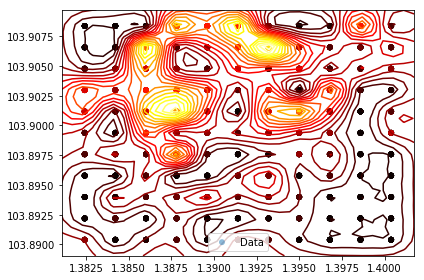

In [44]:
sk_models[0].plot(fixed_inputs=[(2, 100)])

 /Users/xbili/.pyenv/versions/3.6.2/envs/cs4246/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


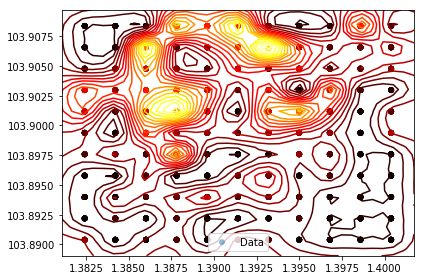

In [37]:
sk_models[0].plot(fixed_inputs=[(2, 2000000)])

# Prediction

Let's run some predictions using our trained models.

In [23]:
def load_data(filename, coordinates):
    data = filter_by_coordinates(np.load(filename), coordinates)    
    X, y = data, data[:,3]
    y -= y.mean()
    X[:,2] -= X[:,2].min()
    
    return X, y

In [24]:
def predict(model, dataset):
    X, y = load_data()

In [25]:
test_sk_datasets = [f'../data/test-sk-filtered_data-{size}.npy' for size in sizes]
test_tp_datasets =[f'../data/test-tp-filtered_data-{size}.npy' for size in sizes]

## Tampines

In [26]:
MAX_AREA = (1.351800, 103.943283, 1.360377, 103.957675)

count = 0
for dataset, model in zip(test_tp_datasets, tp_models):
    print('Predicting for dataset:' + dataset)
    X, y = load_data(dataset, MAX_AREA)
    pred_y = model.predict(X[:,[0, 1, 2]])
    print(mean_squared_error(y, pred_y[0]))
    print(r2_score(y, pred_y[0]))
    
    res = np.concatenate([X, pred_y[0], pred_y[1]], axis=1)
    print(res.shape)
    np.save(f'tp-{count}-result', res)
    count += 1

Predicting for dataset:../data/test-tp-filtered_data-200.npy
1.06047941573
0.830364039219
(2336, 8)
Predicting for dataset:../data/test-tp-filtered_data-400.npy
3.16790222494
0.963250125174
(1552, 8)


## Sengkang

In [27]:
MAX_AREA = (1.382030, 103.888635, 1.402076, 103.909292)

def load_data(filename, coordinates):
    data = filter_by_coordinates(np.load(filename), coordinates)    
    X, y = data, data[:,3]
    y -= y.mean()
    X[:,2] -= X[:,2].min()
    
    return X, y

count = 0
for dataset, model in zip(test_sk_datasets, sk_models):
    print('Predicting for dataset:' + dataset)
    X, y = load_data(dataset, MAX_AREA)
    pred_y = model.predict(X[:,[0, 1, 2]])
    print(mean_squared_error(y, pred_y[0]))
    print(r2_score(y, pred_y[0]))

    res = np.concatenate([X, pred_y[0], pred_y[1]], axis=1)
    print(res.shape)
    np.save(f'sk-{count}-result', res)
    count += 1

Predicting for dataset:../data/test-sk-filtered_data-200.npy
0.320768505738
0.876340758138
(2904, 8)
Predicting for dataset:../data/test-sk-filtered_data-400.npy
1.38575915612
0.91748368825
(2820, 8)
